## Disruptive Marketing, Client behavior change propagation due to a discount

The study focuses on the influence of disruptive marketing  on the customer behavior for a specific cluster of items, here electronic items, the disruption marketing is performed by introducing a discount ads for 24 minutes only on the webpage corresponding the closest item to center of this cluster of items. The closest item is located at index 0 in the precleaned dataframe. The precleaned dataframe, each column represents a specific time (every 24 minutes), each index correponds to an item in a electronic cluster and are ordered by its euclidian distance to the center of cluster of electronic items. The values in each column correspond to number of visit on the specific electronic item webpage weighted to its euclidian distance to the center of the cluster.

**Loading the files of the precleaned dataframe for each time**

In [1]:
from os import walk, getcwd
cwd = getcwd()
mypath = cwd+ '/FM/'
f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break

In [2]:
import pandas as pd
dftot = pd.DataFrame()
ic = 0
for fi in f:
    dfi_inter = pd.read_csv('FM/'+fi,delim_whitespace=True,header=None)
    dfi = dfi_inter.drop(columns=[0,1,3])
    dfi.rename(columns = {2:ic}, inplace = True)
    dftot = pd.concat([dftot, dfi[[ic]]], axis=1)
    ic +=1
dftot.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,2940.4,2937.8,2937.5,2943.7,2955.4,2961.2,2983.8,2973.1,2976.5,2979.5,2979.7,2978.6,2978.9,2979.3,2972.9,2980.6,3004.7,2999.5,3008.4


**Above on can observe the variation of the number of visit for the closest item to the center of the cluster. Below one can observed the weighted number of visit for each item at different times**

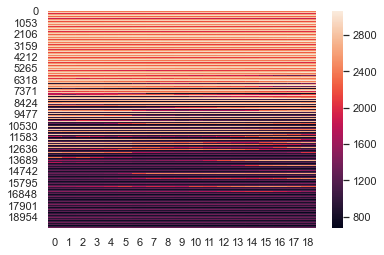

In [21]:
# let's limit to the 20000 closest items
dftot_lim = dftot[:20000]

import seaborn as sns; sns.set()
ax = sns.heatmap(dftot_lim)

**Dynamic mode decomposition code developed during my PhD in ML for thermoacoustics for capturing linear fluctuations in non-linear process. Here the non-linear process is the discount ads**

In [27]:
import numpy as np
from scipy import linalg
import math

def DyMoDec(data_frame,dt=0.001):
    NsubS = data_frame.shape[1] -2
    [RField, CField]= data_frame.shape
    Field1Nm1 = data_frame.iloc[:,1:CField-1].values - data_frame.iloc[:,0:CField-2].values
    Field2N = data_frame.iloc[:,2:CField].values - data_frame.iloc[:,1:CField-1].values
    [Ua,S,Va] = linalg.svd(Field1Nm1)
    ls = S.shape[0]
    PseudoS = 1./S
    PseudoSred = PseudoS[0:NsubS]
    d_PseudoSred  = np.diag(PseudoSred)
    Uared = Ua[:,0:NsubS]
    Vared = Va[:,0:NsubS]
    Arr1 = np.transpose(Uared).dot(Field2N).dot(Vared).dot(d_PseudoSred)
    [LDMD, EVDMD] = linalg.eig(Arr1)
    DM = Uared.dot(EVDMD)
    fr = np.angle(LDMD)/(2*math.pi*dt)
    ksi = np.log2(abs(LDMD))/(dt)
    return LDMD, DM, fr, ksi

# 24 minutes correspond to 1440 seconds
LDMDtot, DMtot, frtot, ksitot = DyMoDec(dftot_lim,dt=1440)  

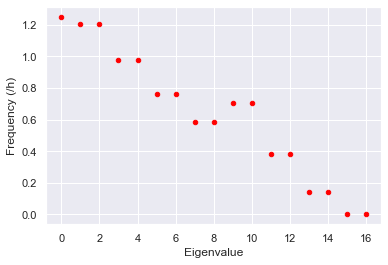

In [28]:
import matplotlib.pyplot as plt
# Frequency is described per hour
df = pd.DataFrame({'Frequency (/h)':abs(frtot*3600)})
df.reset_index(inplace=True)
df.rename(columns = {'index':'Eigenvalue'}, inplace = True)
df.plot.scatter(x='Eigenvalue',y='Frequency (/h)',c="red")
plt.show()

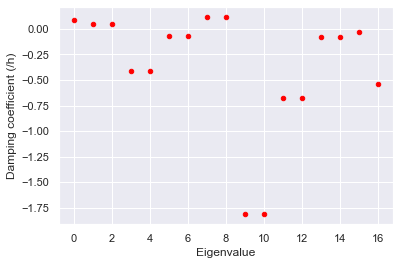

In [29]:
# Frequency is described per hour
df2 = pd.DataFrame({'Damping coefficient (/h)':ksitot*3600})
df2.reset_index(inplace=True)
df2.rename(columns = {'index':'Eigenvalue'}, inplace = True)
df2.plot.scatter(x='Eigenvalue',y='Damping coefficient (/h)',c="red")
plt.show()

**A pair of eigenvalues with the same frequency and damping coefficient corresponds to a propagating sine wave. Here we focus on the pair of eigenvalues with a positive damping coefficient postive. Potive coefficients means to the magnitude of the linear propagation will first grow linearly and increase exponentially until it reaches a maximum i.e. the maximum number of customer potentially interested in electronics on this website.**

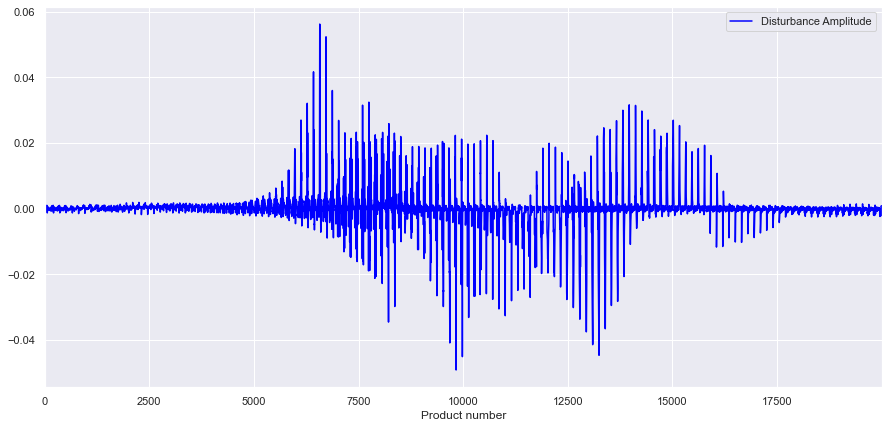

In [30]:
df_DM_real = pd.DataFrame({'Disturbance Amplitude':DMtot[:,8].real})
df_DM_real.reset_index(inplace=True)
df_DM_real.rename(columns = {'index':'Product number'}, inplace = True)
df_DM_real.plot(x='Product number',y='Disturbance Amplitude',c="blue",figsize=(15,7))
plt.show()

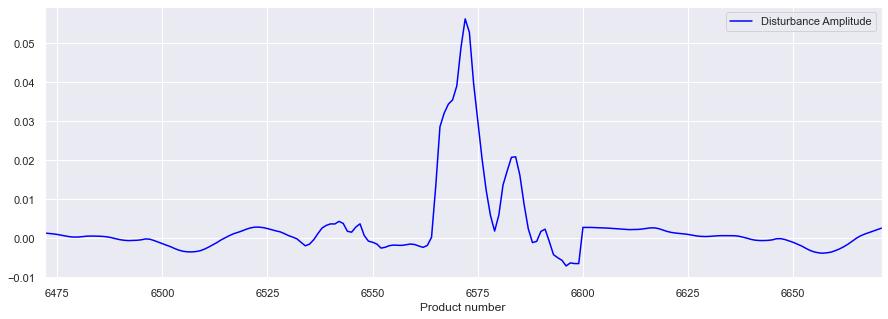

In [49]:
#checking the wave, can change the brandwith brw
brw = 100
a = df_DM_real[['Disturbance Amplitude']].idxmax()[0] - brw
b = df_DM_real[['Disturbance Amplitude']].idxmax()[0] + brw
df_DM_real_brw = df_DM_real[a:b]
df_DM_real_brw.plot(x='Product number',y='Disturbance Amplitude',c="blue",figsize=(15,5))
plt.show()

**Above one can observed the sine wave corresponding the eigenvalue 8, the magnitude of wave itself is not important since we have computed that this wave will grow in amplotude. We see its influence on the number of visit for each item webpage by looking at the amplitude. The wave propagates as the time goes towards the items more distant to the cluster center.**  

**Let's compute the wavelength and the speed of this wave to see how fast the disturbance generated by adding the ads propagates to all the items in the cluster.**

In [52]:
#wl = 2*abs(DM1_real.idxmax() - DM1_real.idxmin())[0]
wl = 2*abs(df_DM_real_brw[['Disturbance Amplitude']].idxmax()[0] - df_DM_real_brw[['Disturbance Amplitude']].idxmin()[0])
#df_DM_real[['Disturbance Amplitude']].idxmax()[0]
propa_speed = wl*df['Frequency (/h)'].iloc[8].round(1)
print('The wavelength covers', wl, "items")
print('The wave propagates at a speed of', propa_speed, "items per hour")

The wavelength covers 48 items
The wave propagates at a speed of 28.799999999999997 items per hour


**The wavelength of the eigenvalue 8 is 48 items which represents less than 1% of all the item (48/20000 = 0.24%) and a low speed of propagation. It takes 694.44 hours (almost 29 days) to cover all the items. This wave gives a positive impact on the number of visit nevertheless (the damping coefficient is positive meaning that the amplitude of the wave will expand until it satures). Similar study can be perform on eigenvalues with a positive damping coefficient.** 

**Future work: Introducing a discount ads for a bigger range of items for 24 minutes, for instance for the top 10, top 1000 and the top 1000 items and look if wavelength and the speed of progation changes in order to a campaign that generates a larger impact at a faster paste**